1. Setup and Initialization

In [6]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Activation, Add, Dense, Conv2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers import BatchNormalization, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix

2. Dataset Analysis

In [7]:
# Define the path where our dataset is stored
dataset_path = '../data/TrashNet'

# Retrieve the names of all folders (representing trash types) within the dataset directory
garbage_types = os.listdir(dataset_path)

# Set to store unique image dimensions for the entire dataset
all_dimensions_set = set()

# Iterate over each trash type (folder) to process images
for garbage_type in garbage_types:
    folder_path = os.path.join(dataset_path, garbage_type)
    
    # Verify that the current item is a directory
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg'))]
        
        # Display the count of images in the current folder
        num_images = len(image_files)
        print(f"{garbage_type} folder contains {num_images} images.")
        
        # Loop over each image to check its dimensions
        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            with Image.open(image_path) as img:
                # Extract the width, height, and channels (color depth) of the image and add to the dimensions set
                width, height = img.size
                channels = len(img.getbands())
                all_dimensions_set.add((width, height, channels))
                
# Determine if all images in the entore dataset have the same dimensions 
if len(all_dimensions_set) == 1: 
    width, height, channel = all_dimensions_set.pop()
    print(f"\nAll images in the dataset have the same dimensions: {width}x{height} with {channels} color channels.")
else:
    print("\nThe images in the dataset have different dimensions or color channels.")


paper folder contains 594 images.
metal folder contains 410 images.
cardboard folder contains 403 images.
trash folder contains 137 images.
glass folder contains 501 images.
plastic folder contains 482 images.

All images in the dataset have the same dimensions: 512x384 with 3 color channels.


Inference on Class Imbalance:
The Dataset has  imbalance in the distribution of its image categories, which can lead to bias, generalization issues, accuracy deception:

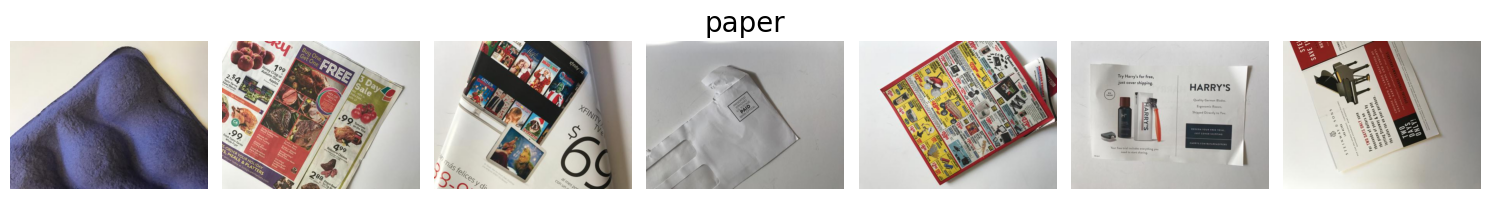

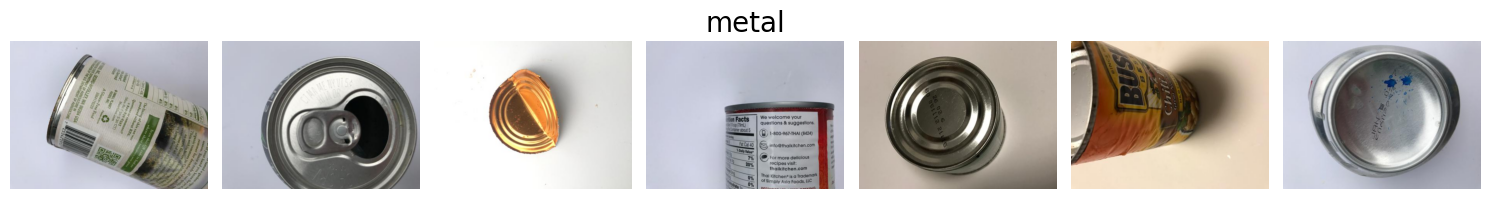

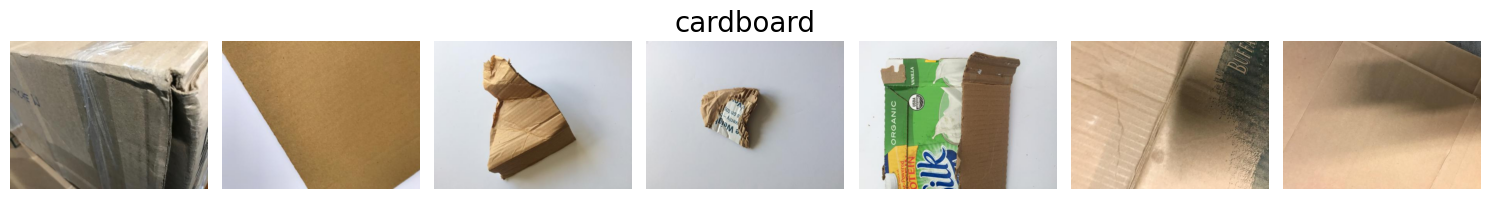

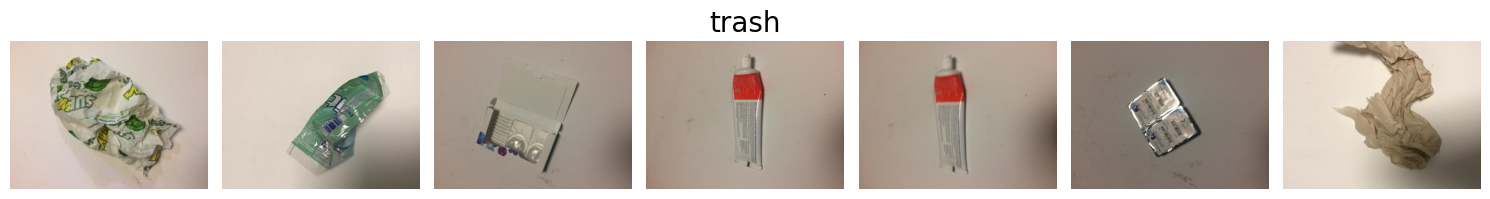

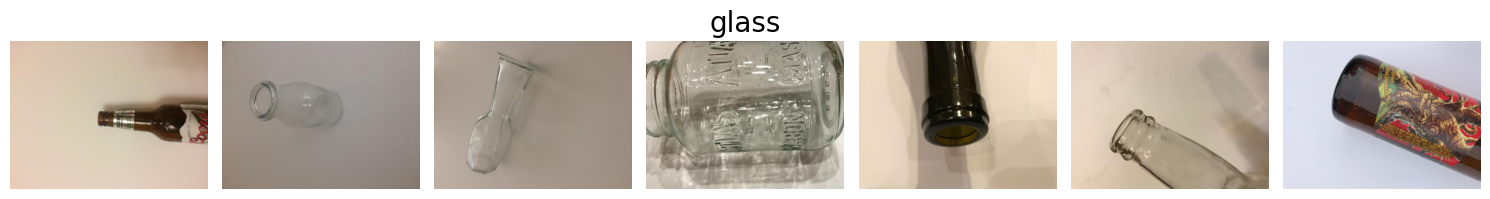

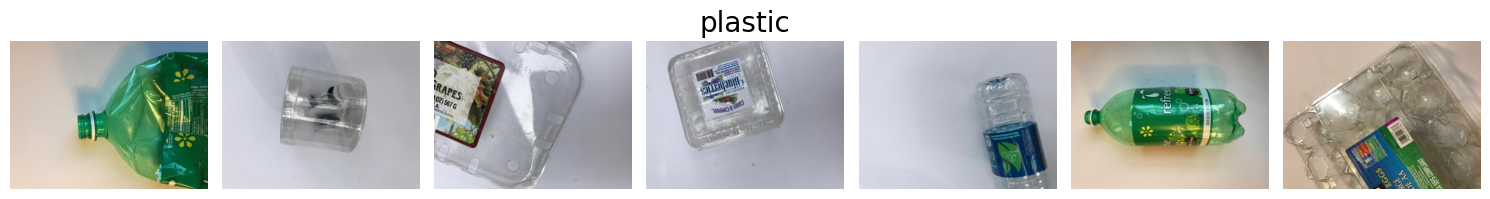

In [8]:
# Iterate over each trash type (folder) to display images
for garbage_type in garbage_types:
    folder_path = os.path.join(dataset_path, garbage_type)
    
    # Verify that the current item is a directory
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg'))]
        
        # Select the first 10 images
        image_files = image_files[:7]
        
        # Set up subplots
        fig, axs = plt.subplots(1, 7, figsize=(15, 2))
        
        for i, image_file in enumerate(image_files):
            image_path = os.path.join(folder_path, image_file)
            with Image.open(image_path) as img:
                axs[i].imshow(img)
                axs[i].axis('off')
        
        plt.tight_layout()
        fig.suptitle(garbage_type, fontsize=20, y=1.03)
        plt.show()

3. Dataset Preparation

3.1. Centralize Dataset Information: Create a DataFrame that contains file paths and corresponding labels.

In [10]:
# Initialize an empty list to store image file paths and their respective labels
data = []

# Loop through each garbage type and collect its images' file paths
for garbage_type in garbage_types:
    folder_path = os.path.join(dataset_path, garbage_type)
    # Ensure the item is a directory to skip over any non-directory files like .DS_Store
    if os.path.isdir(folder_path):
        for file in os.listdir(os.path.join(dataset_path, garbage_type)):
            # Append the image file path and its trash type (as a label) to the data list
            data.append((os.path.join(dataset_path, garbage_type, file), garbage_type))

# Convert the collected data into a DataFrame
df = pd.DataFrame(data, columns=['filepath', 'label'])

# Display the first few entries of the DataFrame
df.head()

,filepath,label
0,../data/TrashNet/paper/paper283.jpg,paper
1,../data/TrashNet/paper/paper297.jpg,paper
2,../data/TrashNet/paper/paper526.jpg,paper
3,../data/TrashNet/paper/paper240.jpg,paper
4,../data/TrashNet/paper/paper254.jpg,paper


3.2. Data Splitting: Train & Validation

In [11]:
# Split with stratification
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Print the number of images in each set
print(f"Number of images in the training set: {len(train_df)}")
print(f"Number of images in the validation set: {len(val_df)}")

Number of images in the training set: 2021
Number of images in the validation set: 506


In [12]:
# 1. Class distribution in the entire dataset
overall_distribution = df['label'].value_counts(normalize=True) * 100

# 2. Class distribution in the training set
train_distribution = train_df['label'].value_counts(normalize=True) * 100

# 3. Class distribution in the validation set
val_distribution = val_df['label'].value_counts(normalize=True) * 100

print("Class distribution in the entire dataset:\n")
print(overall_distribution.round(2))
print('-'*40)

print("\nClass distribution in the training set:\n")
print(train_distribution.round(2))
print('-'*40)

print("\nClass distribution in the validation set:\n")
print(val_distribution.round(2))

Class distribution in the entire dataset:

label
paper        23.51
glass        19.83
plastic      19.07
metal        16.22
cardboard    15.95
trash         5.42
Name: proportion, dtype: float64
----------------------------------------

Class distribution in the training set:

label
paper        23.50
glass        19.84
plastic      19.05
metal        16.23
cardboard    15.93
trash         5.44
Name: proportion, dtype: float64
----------------------------------------

Class distribution in the validation set:

label
paper        23.52
glass        19.76
plastic      19.17
metal        16.21
cardboard    16.01
trash         5.34
Name: proportion, dtype: float64


3.3. Data Augmentation & Rescaling

Augment the training images to artificially increase dataset size.

Rescale both training and validation images for better network performance.

In [13]:
# Slight Augmentation settings for training
train_datagen = ImageDataGenerator(
    rescale=1./255,                     # Normalize pixel values to [0,1]
    rotation_range=45,                  # Randomly rotate the images by up to 45 degrees
    width_shift_range=0.15,             # Randomly shift images horizontally by up to 15% of the width
    height_shift_range=0.15,            # Randomly shift images vertically by up to 15% of the height
    zoom_range=0.15,                    # Randomly zoom in or out by up to 15%
    horizontal_flip=True,               # Randomly flip images horizontally
    vertical_flip=True,                 # Randomly flip images vertically
    shear_range=0.05,                   # Apply slight shear transformations
    brightness_range=[0.9, 1.1],        # Vary brightness between 90% to 110% of original
    channel_shift_range=10,             # Randomly shift channels (can change colors of images slightly but less aggressively)
    fill_mode='nearest'                 # Fill in missing pixels using the nearest filled value
)

# Only rescaling for validation
val_datagen = ImageDataGenerator(rescale=1./255)

3.4. Generating Batches of Images

In [14]:
# Using flow_from_dataframe to generate batches
# Generate training batches from the training dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,                  # DataFrame containing training data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(384, 384),              # Resize all images to size of 384x384
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)


# Generate validation batches from the validation dataframe
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,                    # DataFrame containing validation data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(384, 384),              # Resize all images to size of 384x384
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)


Found 2021 validated image filenames belonging to 6 classes.
Found 506 validated image filenames belonging to 6 classes.


In [15]:
print(f"Number of batches in train_generator: {len(train_generator)}")
print(f"Number of batches in val_generator: {len(val_generator)}")

Number of batches in train_generator: 64
Number of batches in val_generator: 16


4. Addressing Dataset Imbalances

In [16]:
# Extract class labels from the 'label' column of train_df
class_labels = train_df['label'].unique()
class_labels

array(['trash', 'glass', 'paper', 'metal', 'plastic', 'cardboard'],
      dtype=object)

In [17]:
train_generator.class_indices

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [18]:
# Compute class weights
weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=train_df['label'])
weights

array([3.06212121, 0.83998337, 0.70912281, 1.02693089, 0.87489177,
       1.04606625])

In [19]:
# Convert the computed weights to a dictionary for passing to model training
class_weights = dict(zip(train_generator.class_indices.values(), weights))
class_weights

{0: np.float64(3.062121212121212),
 1: np.float64(0.8399833748960931),
 2: np.float64(0.7091228070175438),
 3: np.float64(1.026930894308943),
 4: np.float64(0.8748917748917749),
 5: np.float64(1.0460662525879918)}